In [1]:
import numpy as np
from types import SimpleNamespace
from scipy import optimize
from matplotlib import pyplot as plt

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [11]:
# define parameter namespace
par = SimpleNamespace()
par.eta = 0.5
par.w = 1.0

# preliminary possible values for kappa 
kappa = [1.0, 2.0] # deman shock

def profits(par, ell, kappa):
    return kappa*ell**(1-par.eta)-par.w*ell

def ell_opt_anal(par, kappa):

    """ given parameters, w and eta, and possible kappas (list) return analytic solution """
    ell_opt = [None]*len(kappa)
    for i, k in enumerate(kappa):
        ell_opt[i] = ((1-par.eta)*k/par.w)**(1/par.eta)
    return ell_opt

def ell_opt_rulebased(par, kappa): #rule ell fors question 2.3 
    return ((1-par.eta)*kappa/par.w)**(1/par.eta)

def sol_ell(par, kappa):
    # allocate 
    res = [None] * len(kappa)

    for i, k in enumerate(kappa):

        # optimize with scipy
        obj = lambda ell: -profits(par, ell, k)
        x0 = [0.1]

        # store results 
        res[i] = optimize.minimize(obj, x0=x0, method='nelder-mead', bounds=((0, np.inf), ))
    return res

In [120]:
res = sol_ell(par, kappa)
opt_anal = ell_opt_anal(par, kappa)
print(res[0].x, res[1].x,opt_anal)

# profit for kappa 1 
print(profits(par, res[0].x, kappa=1))
print(profits(par, res[1].x, kappa=2))


[0.25] [1.] [0.25, 1.0]
[0.25]
[1.]


Optimizing numerically we find the same solution as the analytical solution. We can check this further by using the numpy "isclose" function, using this we again find that the numerical and analytical solution is the same:

In [13]:
print(np.isclose(res[0].x,opt_anal[0]),
np.isclose(res[1].x, opt_anal[1]))

[ True] [ True]


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [121]:
# a. deffine new parameters
# i. baseline parameters
par.rho = 0.90
par.iota = 0.01
par.sigma = 0.1
par.R = (1+0.01)**(1/12)

# ii. initial values and periods 
par.kappa_init = 1
par.T = 120

# b. generate kappa series from par
def kappa_series(par):
    # allocate 
    log_kappa_ar1 = np.zeros(par.T)

    eps = np.random.normal(-0.5*par.sigma**2, par.sigma, par.T) #create T choks

    log_kappa_ar1[0] = par.rho*np.log(par.kappa_init)  # sholud eps[0] be removed?
    
    for i in range(1,par.T):
        log_kappa_ar1[i] = par.rho*log_kappa_ar1[i-1] + eps[i]

    kappa_ar1 = np.exp(log_kappa_ar1)
    return kappa_ar1

# C. CHECK
np.random.seed(1234)
check = kappa_series(par)
check


array([1.        , 0.88329365, 1.02693936, 0.98773524, 0.91560942,
       1.00437698, 1.0885968 , 1.00777832, 1.00354932, 0.79765448,
       0.91076697, 1.01012412, 1.10450614, 0.88899203, 0.86562106,
       0.8740083 , 0.91791221, 0.94821029, 1.08248004, 0.91543008,
       0.9005138 , 0.84797193, 0.87452462, 0.93209228, 1.0655851 ,
       1.00525487, 1.0695868 , 0.88147595, 0.87209872, 0.97797568,
       0.93722917, 0.97083288, 1.07585642, 1.17986395, 1.25889072,
       1.20924803, 1.19538717, 1.1312731 , 1.20946334, 1.49968505,
       1.44390257, 1.3086159 , 1.27212306, 1.00412923, 1.02376589,
       0.92906498, 0.9186056 , 0.92350446, 0.99892029, 1.0156762 ,
       1.0975715 , 0.93632654, 0.81512873, 0.81950062, 0.78743193,
       0.79093264, 0.83469726, 0.84267926, 0.90259787, 1.05901109,
       0.95044817, 0.94386327, 0.97414055, 0.95177217, 1.05537213,
       0.82156743, 1.02139896, 0.90464993, 0.92867339, 0.99887434,
       0.91891911, 0.96570634, 1.03460207, 1.08108589, 0.97291

In [122]:
def h_func_q2(par, shocks):

    # allocate
    profit_series = np.zeros(par.T)
    ell_series = np.empty(par.T)

    # rulebased choice of ell!
    for i,s  in enumerate(shocks):
        ell_series[i] = ell_opt_rulebased(par, s)

    for i in range(par.T): 
        
        # check for adj cost. 
        if i >= 1 and ell_series[i] != ell_series[i-1]:
            adj_cost = par.iota
        else:
            adj_cost = 0
        
        # calculate profit 
        profit_series[i] = par.R**(-i) * (profits(par, ell_series[i], shocks[i]) - adj_cost)

    return np.sum(profit_series)

def big_H_q2(par):
    h_list = np.empty(par.K)
    for i in range(par.K):
        shocks = kappa_series(par)
        h_list[i] = h_func_q2(par, shocks)
        # print(h_list[i])

    return np.mean(h_list)

In [139]:
par.K = 5000
# np.random.seed(1234) # 27.65862396523636 # 27.674273334372586 # 27.69798671291177 # 27.574765784559666

result = big_H_q2(par)
print(result)

27.574765784559666


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [191]:
# write your code here
def h_func_q3(par, shocks):

    # allocate
    profit_series = np.zeros(par.T)
    ell_series = np.empty(par.T)

    # rulebased choice of ell!
    for i,s  in enumerate(shocks):
        ell_series[i] = ell_opt_rulebased(par, s)

    for i in range(par.T): 
        
        # check for adj cost. 
        if i > 1 and abs(ell_series[i-1] - ell_series[i]) > par.Delta:
            adj_cost = par.iota
        else:
            adj_cost = 0
            ell_series[i] = ell_series[i-1]
        
        # calculate profit 
        profit_series[i] = par.R**(-i) * (profits(par, ell_series[i], shocks[i]) - adj_cost)

    return np.sum(profit_series)


def big_H_q3(par):
    h_list = np.empty(par.K)
    for i in range(par.K):
        shocks = kappa_series(par)
        print(shocks)
        h_list[i] = h_func_q3(par, shocks)
        # print(h_list[i])
    return np.mean(h_list)


In [192]:
par.Delta= 0.05
profits_high_Delta = big_H_q3(par)
print(profits_high_Delta)

[1.         1.11638999 1.08387649 1.18256148 1.11105075 0.96840867
 0.9126099  1.00073156 0.88303786 0.82608771 0.84797547 1.03656066
 0.92537969 0.93335631 0.94782899 0.90260126 1.16540629 1.21801245
 1.32093889 1.26110844 1.28295671 1.02305444 1.03350959 0.92774291
 1.04778196 0.83655294 0.76725225 0.91570185 1.00507772 1.03338009
 1.10881529 1.08598112 1.15049821 1.23650184 1.20931307 1.26394161
 1.14442096 1.09441654 1.06223675 1.11918399 1.06343914 1.04764138
 0.96791029 0.78362185 0.88442958 0.83884138 0.77615021 0.85882537
 0.91763083 0.94577445 1.12139992 1.26145281 1.18633595 1.11456573
 1.10370375 1.31746544 1.16258351 1.19659069 1.19337802 1.13362817
 1.01825522 1.01107724 0.9811539  0.88202834 0.81003431 0.85163189
 0.95903847 0.90200016 0.90245764 0.98010124 1.01193492 0.92136029
 1.04938238 1.07033712 1.19415946 1.23224328 1.10832588 1.13311261
 1.09075916 1.24787622 0.95328127 0.972844   1.05950876 1.21097332
 1.3248747  1.25437134 1.25474248 1.34158606 1.43862509 1.4564

We see that profitability is not improved for the higher $\Delta$

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [193]:
# write your code here
par.K = 100
def sol_Delta(par):
    def obj(Delta):
        par.Delta = Delta
        np.random.seed(1234)
        return -1* big_H_q3(par)
    bnds = ((0,2),)
    x0 = 0.2
    res = optimize.minimize(obj, x0=x0, method='nelder-mead', bounds = bnds, tol=1e-10)
    return res

In [184]:
optimalDelta = sol_Delta(par)

In [196]:
par.K = 2
def obj(Delta):
        par.Delta = Delta
        np.random.seed(1234)
        return -1* big_H_q3(par)

print(obj(1))
print(obj(0))

[1.         0.88329365 1.02693936 0.98773524 0.91560942 1.00437698
 1.0885968  1.00777832 1.00354932 0.79765448 0.91076697 1.01012412
 1.10450614 0.88899203 0.86562106 0.8740083  0.91791221 0.94821029
 1.08248004 0.91543008 0.9005138  0.84797193 0.87452462 0.93209228
 1.0655851  1.00525487 1.0695868  0.88147595 0.87209872 0.97797568
 0.93722917 0.97083288 1.07585642 1.17986395 1.25889072 1.20924803
 1.19538717 1.1312731  1.20946334 1.49968505 1.44390257 1.3086159
 1.27212306 1.00412923 1.02376589 0.92906498 0.9186056  0.92350446
 0.99892029 1.0156762  1.0975715  0.93632654 0.81512873 0.81950062
 0.78743193 0.79093264 0.83469726 0.84267926 0.90259787 1.05901109
 0.95044817 0.94386327 0.97414055 0.95177217 1.05537213 0.82156743
 1.02139896 0.90464993 0.92867339 0.99887434 0.91891911 0.96570634
 1.03460207 1.08108589 0.97291745 1.18657839 1.18727733 1.03482315
 1.0930866  1.0822651  1.11917273 0.7710355  0.89860814 0.91763613
 0.93621891 0.89823376 0.97545079 1.07371219 1.08990808 1.23575

In [ ]:
from tqdm import tqdm 
par.K = 1000
H = np.empty(100)
Delta = np.linspace(0,10,100)
for i, d in tqdm(enumerate(Delta)):
    par.Delta = d
    H[i] = big_H(par)

0it [00:00, ?it/s]/var/folders/vd/dwydg2bx2gz3j9x78jm_tx400000gn/T/ipykernel_3314/1414605160.py:18: RuntimeWarning: divide by zero encountered in log
  kappa_ar1[i] = par.rho*np.log(kappa_ar1[-1]) + eps[i]
100it [01:59,  1.19s/it]


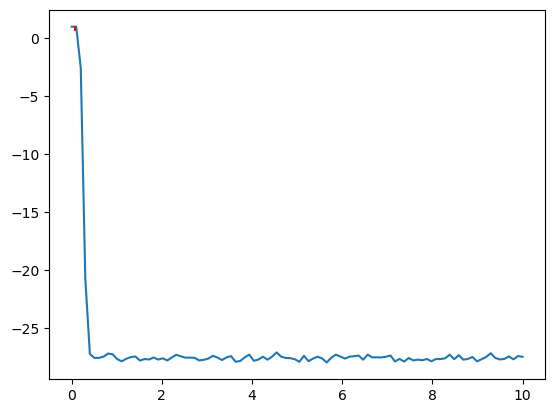

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(Delta, H)
ax.vlines(0.08, ymin=0.6, ymax=1, color='r')


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



**Question 5 Answer:**
We consider making a good guess of kappa and using this kappa in each period and setting a fixed $\ell$. Under the assumption that we as hair salon owners have access the mean of the shocks $-0.5\sigma**2$ and $\rho$.

In [ ]:
# write your code here 
def kappa_guees()